In [57]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.transforms import functional as TF
import random
from tqdm import tqdm # 用於顯示進度條的套件
import matplotlib.pyplot as plt
from PIL import Image

In [58]:
# 設定參數
IMAGE_SIZE = 224
BATCH_SIZE = 256
NUM_CLASSES = 10000  # 有10000個標籤(資料夾)
EPOCHS = 50
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
RANDOM_SEED = 123456
DATA_DIR = "Downloads/畢專/data_set/data"  # 資料集路徑

In [59]:
# 確保可重現性
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
  torch.cuda.manual_seed(RANDOM_SEED)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  print('done')
else:
  print('not done')

done


In [60]:
# 定義模型
class UAVLocalizationModel(nn.Module):
  def __init__(self, num_class = NUM_CLASSES):
    super().__init__()
    self.mobilenet = models.mobilenet_v2(pretrained = True)

    # for name, layers in self.named_children():
    #     print(name, "  ", layers)

    for param in self.mobilenet.parameters():
      param.requires_grad = False

    in_feature = self.mobilenet.classifier[1].in_features
    self.mobilenet.classifier = nn.Sequential(
      # nn.Dropout(0.2),
      nn.Linear(in_feature, num_class)
    )

  def forward(self, x):
    return self.mobilenet(x)

  def unfreeze_layers(self, num_layers=5):
    trainable_params = []
    # 正確訪問mobilenet的features部分
    features = self.mobilenet.features
    # 解凍最後num_layers層
    for i in range(min(0, len(features) - num_layers), len(features)):
      for param in features[i].parameters():
        param.requires_grad = True
        trainable_params.append(param)
        
    # 解凍分類器部分
    for param in self.mobilenet.classifier.parameters():
      param.requires_grad = True
      trainable_params.append(param)
        
    return trainable_params

In [61]:
def is_valid_file_func(path):
  return path.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))
# 加載數據
def load_data():
  train_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])

  train_dataset = datasets.ImageFolder(
    root = DATA_DIR,
    is_valid_file = is_valid_file_func,
    allow_empty = False,
    transform=train_transforms
  )

  train_loader = DataLoader(
    train_dataset,
    batch_size = BATCH_SIZE,
    num_workers=4
  )

  val_loader = DataLoader(
    train_dataset,
    batch_size = BATCH_SIZE,
    num_workers=4
  )

  return train_loader, val_loader, train_dataset.class_to_idx

In [62]:
# 訓練函數
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=EPOCHS):
  history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': []
  }

  best_val_acc = 0.0

  for epoch in range(num_epochs):
    model.train()

    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)

    running_loss = 0.0
    running_corrects = 0

    train_pbar = tqdm(train_loader, desc=f'Training')

    for inputs, labels in train_pbar:
      optimizer.zero_grad()

      with torch.set_grad_enabled(True):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

      running_loss += loss.item() * inputs.size(0)
      running_corrects += (preds == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects / len(train_loader.dataset)
    train_pbar.set_postfix({'loss': loss.item()})

    history['train_loss'].append(epoch_loss)
    history['train_acc'].append(epoch_acc)

    print(f'Training Loss: {epoch_loss:.4f} Acc: {epoch_acc*100:.4f}%')

    # 驗證階段
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    val_pbar = tqdm(val_loader, desc=f'Validation')

    for inputs, labels in val_pbar:
      with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

      running_loss += loss.item() * inputs.size(0)
      running_corrects += (preds == labels).sum().item()

    val_pbar.set_postfix({'loss': loss.item()})
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_acc = running_corrects / len(val_loader.dataset)

    print(f'Val Loss: {epoch_loss:.4f} Acc: {epoch_acc*100:.4f}%')

    # 記錄歷史
    history['val_loss'].append(epoch_loss)
    history['val_acc'].append(epoch_acc)

    # 保存最佳模型
    if epoch_acc > best_val_acc:
      best_val_acc = epoch_acc
      torch.save(model.state_dict(), 'Downloads/畢專/AI model/uav_localization_best_model.pth')
      print(f'保存最佳模型，準確率: {epoch_acc*100:.4f}%')

  # 加載最佳模型權重
  model.load_state_dict(torch.load('Downloads/畢專/AI model/uav_localization_best_model.pth'))

  return model, history

In [63]:
# 評估模型
def evaluate_model(model, test_loader):
  return None

In [64]:
# 繪製訓練曲線
def plot_training_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

  ax1.plot(history['train_loss'], label='Train Loss')
  ax1.plot(history['val_loss'], label='Val Loss')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Loss')
  ax1.legend()
  ax1.set_title('Training and Validation Loss')

  ax2.plot(history['train_acc'], label='Train Accuracy')
  ax2.plot(history['val_acc'], label='Val Accuracy')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')
  ax2.legend()
  ax2.set_title('Training and Validation Accuracy')

  plt.tight_layout()
  plt.savefig('training_history.png')
  plt.show()

In [65]:
print("載入數據...")
train_loader, val_loader, class_to_idx = load_data()

載入數據...


In [66]:
print("創建模型...")
model = UAVLocalizationModel(NUM_CLASSES)

創建模型...


In [67]:
# !nvidia-smi
# if torch.cuda.is_available():
#   print("GPU is available")
# else:
#   print("GPU is not available")


In [68]:
# 預測函數
def predict_position(model, image_path, class_to_idx):
    idx_to_class = {v: k for k, v in class_to_idx.items()}
    
    transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)
    
    # 進行預測
    model.eval()
    with torch.no_grad():
        outputs = model(image)
        _, preds = torch.max(outputs, 1)
    
    predicted_idx = preds.item()
    predicted_class = idx_to_class[predicted_idx]
    
    # 計算置信度
    probabilities = torch.nn.functional.softmax(outputs, dim=1)[0]
    confidence = probabilities[predicted_idx].item()
    
    return predicted_class, confidence

In [69]:
# 第一階段：只訓練分類器層
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.mobilenet.classifier.parameters(), lr=LEARNING_RATE)
print("開始第一階段訓練...")
model, first_history = train_model(
  model,
  train_loader,
  val_loader,
  criterion,
  optimizer,
  num_epochs=int(EPOCHS/5)
)

開始第一階段訓練...
Epoch 1/10
----------


Training: 100%|██████████| 40/40 [04:41<00:00,  7.03s/it]


Training Loss: 12.2327 Acc: 0.0000%


Validation: 100%|██████████| 40/40 [03:38<00:00,  5.46s/it]


Val Loss: 8.7568 Acc: 2.6100%
保存最佳模型，準確率: 2.6100%
Epoch 2/10
----------


Training: 100%|██████████| 40/40 [04:39<00:00,  6.99s/it]


Training Loss: 8.1650 Acc: 10.8000%


Validation: 100%|██████████| 40/40 [03:37<00:00,  5.43s/it]


Val Loss: 7.0552 Acc: 21.6900%
保存最佳模型，準確率: 21.6900%
Epoch 3/10
----------


Training: 100%|██████████| 40/40 [04:39<00:00,  6.98s/it]


Training Loss: 6.0141 Acc: 56.9900%


Validation: 100%|██████████| 40/40 [03:40<00:00,  5.51s/it]


Val Loss: 5.6295 Acc: 71.1400%
保存最佳模型，準確率: 71.1400%
Epoch 4/10
----------


Training: 100%|██████████| 40/40 [04:41<00:00,  7.05s/it]


Training Loss: 3.9933 Acc: 98.8600%


Validation: 100%|██████████| 40/40 [03:37<00:00,  5.43s/it]


Val Loss: 4.3773 Acc: 78.8000%
保存最佳模型，準確率: 78.8000%
Epoch 5/10
----------


Training: 100%|██████████| 40/40 [04:39<00:00,  7.00s/it]


Training Loss: 2.2413 Acc: 100.0000%


Validation: 100%|██████████| 40/40 [03:35<00:00,  5.39s/it]


Val Loss: 3.3853 Acc: 82.9700%
保存最佳模型，準確率: 82.9700%
Epoch 6/10
----------


Training: 100%|██████████| 40/40 [04:42<00:00,  7.07s/it]


Training Loss: 1.0444 Acc: 100.0000%


Validation: 100%|██████████| 40/40 [03:55<00:00,  5.88s/it]


Val Loss: 2.7607 Acc: 84.6500%
保存最佳模型，準確率: 84.6500%
Epoch 7/10
----------


Training: 100%|██████████| 40/40 [09:42<00:00, 14.57s/it]


Training Loss: 0.4854 Acc: 100.0000%


Validation: 100%|██████████| 40/40 [03:34<00:00,  5.37s/it]


Val Loss: 2.4164 Acc: 86.2100%
保存最佳模型，準確率: 86.2100%
Epoch 8/10
----------


Training: 100%|██████████| 40/40 [04:38<00:00,  6.95s/it]


Training Loss: 0.2801 Acc: 100.0000%


Validation: 100%|██████████| 40/40 [03:35<00:00,  5.39s/it]


Val Loss: 2.2210 Acc: 87.0400%
保存最佳模型，準確率: 87.0400%
Epoch 9/10
----------


Training: 100%|██████████| 40/40 [04:38<00:00,  6.96s/it]


Training Loss: 0.1926 Acc: 99.9800%


Validation: 100%|██████████| 40/40 [03:34<00:00,  5.36s/it]


Val Loss: 2.0905 Acc: 87.3800%
保存最佳模型，準確率: 87.3800%
Epoch 10/10
----------


Training: 100%|██████████| 40/40 [04:38<00:00,  6.97s/it]


Training Loss: 0.1446 Acc: 99.9900%


Validation: 100%|██████████| 40/40 [03:35<00:00,  5.39s/it]


Val Loss: 1.9924 Acc: 87.5400%
保存最佳模型，準確率: 87.5400%


In [70]:
# 繪製訓練曲線
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Val Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.set_title('Training and Validation Loss')
    
    ax2.plot(history['train_acc'], label='Train Accuracy')
    ax2.plot(history['val_acc'], label='Val Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.set_title('Training and Validation Accuracy')
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

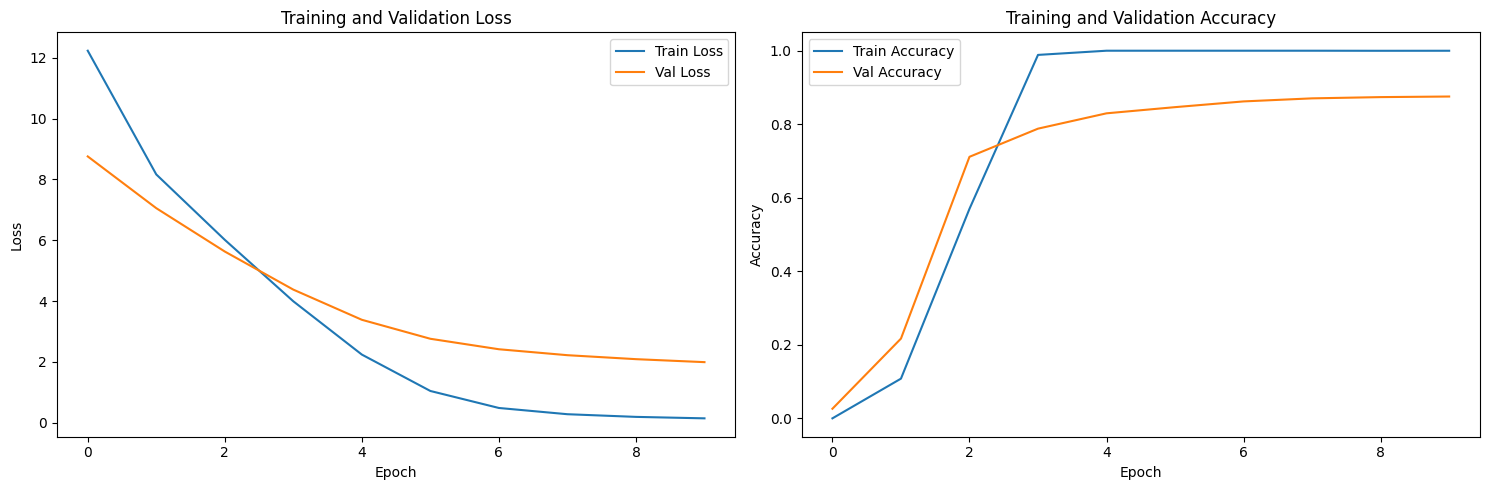

In [72]:
plot_training_history(first_history)
image_path = "Downloads/畢專/data_set/data/24.179516 120.649011/fcu_satellite_78_12_o.png"

In [ ]:
# # 微調模型
# print("開始微調模型...")
# trainable_params = model.unfreeze_layers(5)
# # print(trainable_params)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(trainable_params, lr=LEARNING_RATE)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    
# model, history = train_model(
#     model, 
#     train_loader, 
#     val_loader, 
#     criterion, 
#     optimizer,
#     scheduler=scheduler,
#     num_epochs=EPOCHS // 5
# )

In [ ]:
# 合併歷史記錄
# history = {
#     'train_loss': first_history['train_loss'] + second_history['train_loss'],
#     'val_loss': first_history['val_loss'] + second_history['val_loss'],
#     'train_acc': first_history['train_acc'] + second_history['train_acc'],
#     'val_acc': first_history['val_acc'] + second_history['val_acc']
# }
    
# 繪製訓練歷史
plot_training_history(history)
    
# 保存最終模型
torch.save(
    {
        'model_state_dict': model.state_dict(),
        'class_to_idx': class_to_idx
    }, 
    'uav_localization_final_model.pth'
)
    
 print("模型訓練完成，已保存最終模型")